# Creating a Topic Model Using Gensim 

Model selection is based on coherence score. 

Reference [gensim topic mining tutorial](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/) by [Selva Prabhakaran](https://www.machinelearningplus.com/author/selva86/).

In [1]:
import os
import re
import lxml # added to speed up processing
import numpy as np
import pandas as pd
import metapy
from pprint import pprint
from collections import OrderedDict
import gensim
import gensim.corpora as corpora
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, remove_stopwords, strip_tags, strip_numeric, strip_non_alphanum
from gensim.models import CoherenceModel, Phrases
from bs4 import BeautifulSoup
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from ranker import load_ranker

# Creating a Corpus

The first step is to create a corpus to use for modeling.

In [2]:
top_directory = "../compiled_bios"
filters_path = "../"
def get_array_from_file(filters_path):
    array_file = open(filters_path, 'r')
    array = re.split(' |\n|\t', array_file.read().lower())
    array_file.close()
    array = [arr.replace('\r', '') for arr in array if len(arr.replace('\r', '')) > 0]
    return set(array)

def iter_documents(top_directory, filters):
    custom_filter = [lambda x: x.lower(), strip_punctuation, remove_stopwords, strip_tags, strip_non_alphanum, strip_numeric]
    """Iterate over all documents, yielding a document (=list of utf8 tokens) at a time."""
    for root, dirs, files in os.walk(top_directory):
        for file in filter(lambda file: file.endswith('.txt'), files):
            document = open(os.path.join(root, file)).read().lower() # read the entire document, as one big string
            soup = BeautifulSoup(document, "lxml")
            document = soup.get_text(separator='\n').split(' ')
            document = preprocess_string(' '.join(document), custom_filter)
            document = [word for word in document if word not in filters]
            document = [word for word in document if len(word) > 4]
            
            yield document 

class CorpusContainer(object):
    def __init__(self, top_dir, filters_path):
        self.top_dir = top_dir
        filter_set = self.__construct_filter_set(filters_path) 
        self.docs = list(iter_documents(top_dir, filter_set))
        self.bigram = Phrases(self.docs, min_count=2)
        self.trigram = Phrases(self.bigram[self.docs], min_count=2)
        self.__append_bigrams_and_trigrams()
        self.dictionary = gensim.corpora.Dictionary(self.docs)
        self.dictionary.filter_extremes(no_below=10, no_above=.5, keep_n=30000) # check API docs for pruning params
        self.corpus = [self.dictionary.doc2bow(doc) for doc in self.docs]
        
    def __iter__(self):
        for tokens in iter_documents(self.top_dir, self.filters):
            yield self.dictionary.doc2bow(tokens)
            
    def __len__(self):
        return len(self.docs)
    
    def __construct_filter_set(self, filters_path):
        filters = get_array_from_file(filters_path + 'names.txt')
        filters.update(get_array_from_file(filters_path + 'unis'))
        filters.update(get_array_from_file(filters_path + 'urls'))
        filters.update(get_array_from_file(filters_path + 'emails'))
        #filters.update(get_array_from_file(filters_path + 'depts'))
        filters.update(get_array_from_file(filters_path + 'location'))
        #filters.update(get_array_from_file(filters_path + 'unwanted_words.txt'))
        return filters
    
    
    def __append_bigrams_and_trigrams(self):
        for idx in range(len(self.docs)):
            bigrams = [bigram for bigram in self.bigram[self.docs[idx]] if bigram.count('_') == 1]
            trigrams = [trigram for trigram in self.trigram[self.bigram[self.docs[idx]]] if trigram.count('_') == 2]
        
            for token in bigrams:
                split_tokens = list(OrderedDict.fromkeys(token.split('_')))
                for tok in split_tokens:
                    self.docs[idx] = list(filter(lambda word: word != tok, self.docs[idx]))
                self.docs[idx].append('_'.join(split_tokens))
                
            for token in trigrams:
                split_tokens = list(OrderedDict.fromkeys(token.split('_')))
                for tok in split_tokens:
                    self.docs[idx] = list(filter(lambda word: word != tok, self.docs[idx]))
                self.docs[idx].append('_'.join(split_tokens))
   

corpus_container = CorpusContainer(top_directory, filters_path) # create a dictionary

# Creating Topic Model

gensim LDA algorithm is used.

In [3]:
id2word=corpus_container.dictionary
corpus=corpus_container.corpus
lda_model = gensim.models.ldamodel.LdaModel(
corpus=corpus,
id2word=id2word,
num_topics=20,
passes=10,
per_word_topics=True) 
pprint(lda_model.print_topics())

[(0,
  '0.008*"algebra_combinatorics" + 0.008*"dissertation_thesis" + '
  '0.008*"seminar_discrete" + 0.008*"class_substitution" + '
  '0.008*"programs_masters" + 0.008*"graduate_studies" + '
  '0.005*"schools_colleges" + 0.005*"resources" + 0.004*"current_students" + '
  '0.004*"reservation_request"'),
 (1,
  '0.015*"courses_seminars" + 0.011*"students_courses_seminars" + '
  '0.009*"business_association" + 0.009*"career_impact" + '
  '0.007*"management_organizations" + 0.006*"global_economics" + '
  '0.006*"global_management" + 0.005*"operations_management" + '
  '0.005*"media_entertainment" + 0.004*"accounting_minor"'),
 (2,
  '0.006*"based" + 0.006*"applied_physics" + 0.005*"applications" + '
  '0.004*"systems" + 0.004*"urbana_champaign" + 0.003*"design" + '
  '0.003*"modeling" + 0.003*"physics" + 0.003*"analysis" + 0.003*"materials"'),
 (3,
  '0.010*"academicsour_peopleour" + 0.008*"suggestions_query" + '
  '0.006*"biology_lunch" + 0.006*"postgraduate_opportunities" + '
  '0.005*"

In [4]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus_container.docs, dictionary=corpus_container.dictionary, coherence='c_v')
coherence_model_lda.get_coherence()

0.5248162558054783

In [5]:
def topic_number_evaluator(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_vals = []
    models = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           passes=10,
                                           per_word_topics=True) 
                                         
        models.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_vals.append(coherence_model.get_coherence())
        
    return models, coherence_vals

In [6]:
models, coherence_vals= topic_number_evaluator(corpus_container.dictionary, corpus_container.corpus, corpus_container.docs, start=10, limit=100, step=5)

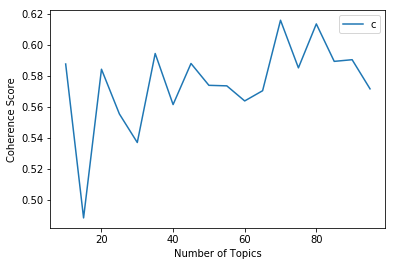

In [7]:
limit = 100
start = 10
step = 5
x = range(start, limit, step)
plt.plot(x, coherence_vals)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_vals"), loc='best')
plt.show()

In [8]:
for m, cv in zip(x, coherence_vals):
    print("Num topics = ", m, " has coherence value of", round(cv, 4))

Num topics =  10  has coherence value of 0.5733
Num topics =  15  has coherence value of 0.5483
Num topics =  20  has coherence value of 0.5105
Num topics =  25  has coherence value of 0.5514
Num topics =  30  has coherence value of 0.575
Num topics =  35  has coherence value of 0.5438
Num topics =  40  has coherence value of 0.5906
Num topics =  45  has coherence value of 0.6124
Num topics =  50  has coherence value of 0.5944
Num topics =  55  has coherence value of 0.6136
Num topics =  60  has coherence value of 0.5896
Num topics =  65  has coherence value of 0.5697
Num topics =  70  has coherence value of 0.6102
Num topics =  75  has coherence value of 0.591
Num topics =  80  has coherence value of 0.5495
Num topics =  85  has coherence value of 0.5987
Num topics =  90  has coherence value of 0.5917
Num topics =  95  has coherence value of 0.5536


In [13]:
optimal_model = models[9]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

[(32,
  '0.038*"medical_education" + 0.033*"biomedical_informatics" + '
  '0.027*"programs_educational" + 0.024*"health_informatics" + '
  '0.018*"innovation_medical" + 0.018*"informatics_fellowship" + '
  '0.018*"leadership_innovation_medical" + 0.018*"centered_technologies" + '
  '0.018*"informatics_patient" + 0.018*"online_clinical"'),
 (11,
  '0.019*"course_schedule" + 0.018*"campus_tours" + '
  '0.014*"mechanical_aerospace" + 0.010*"visit_ottawa" + '
  '0.009*"youtube_instagram" + 0.009*"facebook_twitter" + '
  '0.008*"health_safety" + 0.008*"facilities_administration" + '
  '0.008*"advising" + 0.007*"support_facilities_administration"'),
 (37,
  '0.024*"suggestions_query" + 0.016*"postgraduate_opportunities" + '
  '0.012*"browse_courses" + 0.012*"doctoral_training" + 0.011*"academic" + '
  '0.010*"services" + 0.009*"facilities" + 0.009*"cookie_policy" + '
  '0.008*"summer_schools" + 0.008*"select_level"'),
 (20,
  '0.045*"conference_paper" + 0.020*"human_factors" + 0.017*"article

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
23     10.770429        1       1  0.231983 -0.157453
19      9.167161        1       2 -0.085078 -0.052435
13      8.877597        1       3  0.253418  0.048553
22      7.138284        1       4  0.270404 -0.035145
43      5.772025        1       5 -0.126080 -0.048301
5       5.288054        1       6  0.253920 -0.047883
49      4.209509        1       7  0.228782  0.025415
21      3.577184        1       8  0.210296  0.155160
14      3.312876        1       9  0.109283 -0.077247
0       2.461499        1      10  0.177662 -0.062446
3       2.278213        1      11  0.060654  0.248370
48      1.626753        1      12  0.084637 -0.194460
50      1.546838        1      13  0.048785 -0.213979
20      1.524822        1      14  0.118140 -0.003003
24      1.507454        1      15 -0.009509 -0.152517
42      1.453002        1      16 -0.060281 -0.056040
39      1.422620        1      17  0.096376  0.090502
46      1.388594        1      18  0.089472  0.054193
31      1.370788        1      19  0.067052 -0.085053
41      1.366470        1      20 -0.095539 -0.020517
26      1.354406        1      21 -0.131951  0.007153
34      1.303989        1      22 -0.024478 -0.065573
30      1.276465        1      23 -0.023685  0.020294
51      1.190729        1      24  0.021193  0.001677
11      1.170776        1      25 -0.121837  0.035684
35      1.081822        1      26 -0.015882  0.164310
7       1.068186        1      27 -0.157159 -0.005312
36      0.890134        1      28 -0.017217  0.044787
2       0.820963        1      29  0.056800  0.005717
40      0.800684        1      30 -0.136528 -0.164160
1       0.737904        1      31 -0.088925  0.059437
44      0.708417        1      32  0.027264  0.072801
54      0.706209        1      33 -0.019085  0.068105
16      0.704866        1      34 -0.104821  0.045584
52      0.674481        1      35  0.016408  0.079328
47      0.671380        1      36  0.029597  0.005544
18      0.635486        1      37 -0.015264  0.118480
32      0.631311        1      38 -0.046054  0.028485
4       0.629520        1      39 -0.055364  0.045150
33      0.623306        1      40 -0.076739  0.061324
37      0.554842        1      41  0.032176 -0.042783
6       0.546331        1      42 -0.030292 -0.102126
17      0.534160        1      43 -0.071669  0.018777
27      0.522818        1      44 -0.020563  0.016732
28      0.521695        1      45 -0.134857 -0.007450
38      0.494770        1      46 -0.033764  0.122048
53      0.479982        1      47 -0.087317 -0.009750
15      0.471049        1      48 -0.179958 -0.043134
8       0.418084        1      49 -0.051063  0.081167
25      0.401053        1      50 -0.092733  0.035131
29      0.367894        1      51 -0.019734  0.025579
45      0.303378        1      52 -0.075911  0.058349
10      0.260135        1      53 -0.104842 -0.110575
9       0.250581        1      54 -0.038577 -0.000250
12      0.132024        1      55 -0.131546 -0.086242, topic_info=                               Term         Freq        Total Category  \
term                                                                     
6923                    information  9019.000000  9019.000000  Default   
6450                       graduate  7625.000000  7625.000000  Default   
6692                        systems  9141.000000  9141.000000  Default   
3858         proceedings_conference  2973.000000  2973.000000  Default   
9871                       students  4891.000000  4891.000000  Default   
14773                       program  6610.000000  6610.000000  Default   
9716               courses_seminars  4254.000000  4254.000000  Default   
19324                     resources  4128.000000  4128.000000  Default   
27354              machine_learning  5182.000000  5182.000000  Default   
7080                       programs  4330.000000  4330.000000  De

# Saving the Model

Save the model so that I can load it for inference. Due to timcrunch, there are still scope for further tweaking of corpus to get a better topic model. 

In [14]:
optimal_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=55,
                                           passes=10,
                                           per_word_topics=True
                                        )

In [15]:
optimal_model.save('lda_model')

In [16]:
model = gensim.utils.SaveLoad.load('lda_model') # Make sure the model saved properly

# Saving the Dictionary

Because I need to dictionary for inference, I'll go ahead and save it too.

In [13]:
corpus_container.dictionary.save('corpus_dictionary')

In [14]:
corpora.MmCorpus.serialize('lda_corpus', corpus_container.corpus)